In [19]:
import torch 
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset 
from model import Network, BranchedNetwork
from config import get_cfg_defaults
import matplotlib.pyplot as plt 
import cv2
import h5py
import glob
import albumentations as A 
from albumentations.pytorch import ToTensorV2

In [20]:
def get_train_transform():
    return A.Compose(
        [
            A.RandomBrightnessContrast(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.CLAHE(p=0.2),
            A.OneOf([
                A.RandomRain(),
                A.RandomFog(),
                A.Solarize(),
                A.RandomSnow(),
            ], p=0.3),
            A.Normalize(
                mean=(0.2543, 0.2641, 0.2714),
                std=(0.1730, 0.1726, 0.1726)
            ),
            ToTensorV2(),
        ]
    )


def get_val_transform():
    return A.Compose(
        [
            A.Normalize(
                mean=(0.2543, 0.2641, 0.2714),
                std=(0.1730, 0.1726, 0.1726)
            ),
            ToTensorV2(),
        ]
    )

In [26]:
class ImitationLearningDataset(Dataset):
    """CARLA Imitation Learning Dataset"""
    def __init__(
        self,
        cfg,
        mode: str,
    ):
        if mode == "train":
            data_dir = cfg.DATA.TRAIN_DIR
        else:
            data_dir = cfg.DATA.VAL_DIR

        self.files = glob.glob(data_dir + "/*.h5")
        self.transform = (
            get_train_transform() if mode == "train" else get_val_transform()
        )
        self.num_classes = cfg.MODEL.NUM_COMMANDS
        self.branched = cfg.MODEL.BRANCHED

    def __len__(self):
        return len(self.files) * 200

    def __getitem__(self, idx: int):
        filename = self.files[idx // 200] 
        data = h5py.File(filename, 'r') 
        idx = idx % 200  
        
        img = data['rgb'][idx]
        print(img.shape)
        speed = data['targets'][idx][10]
        command = data['targets'][idx][24]

        steer = data['targets'][idx][0] 
        acc = data['targets'][idx][1] 
        brake = data['targets'][idx][2]

        if self.transform is not None:
            image = self.transform(image=img)['image']

        print(image.shape)
        speed = torch.tensor(speed).float()
        command = torch.tensor(command).long()

        steer = torch.tensor(steer).float()
        acc = torch.tensor(acc).float()
        brake = torch.tensor(brake).float()
        
        return image, speed, command, steer, acc, brake 

In [27]:
dataset = ImitationLearningDataset(cfg, "train")

In [28]:
print(len(dataset))

657600


In [29]:
dataloader = DataLoader(
    dataset, batch_size=4, num_workers=4
)

In [30]:
for el in dataloader: 
    print(len(el))
    break 

(88, 200, 3)(88, 200, 3)(88, 200, 3)

(88, 200, 3)
(88, 200, 3)
(88, 200, 3)



NameError: Caught NameError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/johann/dev/conditional-imitation-learning-pytorch/env/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/johann/dev/conditional-imitation-learning-pytorch/env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/johann/dev/conditional-imitation-learning-pytorch/env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_48984/3879310441.py", line 38, in __getitem__
    image = self.transform(image=org_image)['image']
NameError: name 'org_image' is not defined


(88, 200, 3)
(88, 200, 3)
(88, 200, 3)


In [2]:
checkpoint = "/home/johann/dev/conditional-imitation-learning-pytorch/exps/2023-03-25/checkpoints/best.pth"

In [3]:
cfg = get_cfg_defaults()
model = torch.load(checkpoint) 

In [5]:
device = torch.device("cpu")
model.to(device)

BranchedNetwork(
  (perception): PerceptionModule(
    (conv): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [7]:
val_dataset = ImitationLearningDataset(cfg, "train")
val_dataloader = DataLoader(val_dataset, batch_size=cfg.TRAIN.BATCH_SIZE, num_workers=4, shuffle=True)

In [5]:
loss_fn = torch.nn.MSELoss()

In [16]:
for idx, (org_img, img, speed, mask, target) in enumerate(val_dataloader): 
    img = img.to(device)
    speed = speed.to(device)
    mask = mask.to(device)
    target = target.to(device)

    with torch.no_grad(): 
        out = model(img, speed)

    target = target * mask
    out = out * mask 
    print(target[0])
    print(out[0])
    steer_loss = loss_fn(out.reshape((-1, 4, 3))[:, 0], target.reshape((-1, 4, 3))[:, 0])
    acc_loss = loss_fn(out.reshape((-1, 4, 3))[:, 1], target.reshape((-1, 4, 3))[:, 1])
    brake_loss = loss_fn(out.reshape((-1, 4, 3))[:, 2], target.reshape((-1, 4, 3))[:, 2])

    loss = steer_loss + acc_loss + brake_loss  
    print(f"steer_loss: {steer_loss}") 
    print(f"accel_loss: {acc_loss}")
    print(f"brake loss: {brake_loss}")
    print(f"total loss: {loss}")
    loss = loss_fn(out, target)
    print(f"second loss: {loss * 4}") 
    # target = target.reshape((-1, 4, 3))
    # out = out.reshape((-1, 4, 3)) 
    break  

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0726, 0.0000, 1.0000], dtype=torch.float64)
tensor([ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
         0.0000, -0.0130, -0.0203,  0.0596])
steer_loss: 0.11904450637562257
accel_loss: 0.04205304883784483
brake loss: 0.05273004581415451
total loss: 0.21382760102762194
second loss: 0.2842707861333437


0 Target | Prediction
tensor([-0.0398,  0.5000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
         0.0000, -0.0000,  0.0000,  0.0000], dtype=torch.float64) | tensor([ 0.1295, -0.1243,  0.2903,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
        -0.0000, -0.0000, -0.0000,  0.0000])
steer_loss: 0.007162523395409917
accel_loss: 0.05925394568528797
total loss: 0.06641646908069788
1 Target | Prediction
tensor([-0.0355,  0.5000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
         0.0000, -0.0000,  0.0000,  0.0000], dtype=torch.float64) | tensor([ 0.1364, -0.2376, -0.0325,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         0.0000,  0.0000, -0.0000,  0.0000])
steer_loss: 0.007383280681950988
accel_loss: 0.06813011416812202
total loss: 0.07551339485007301


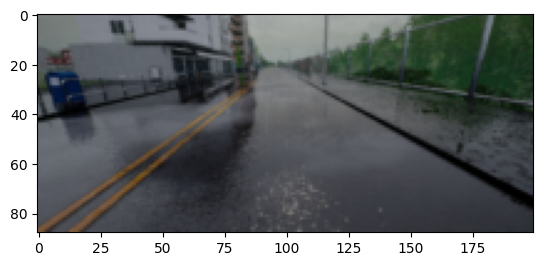

In [6]:
max_idx = 1 
for idx, (org_img, img, speed, mask, target) in enumerate(val_dataset): 
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    plt.imshow(org_img)    
    img = img.to(device).unsqueeze(0)
    speed = speed.to(device).unsqueeze(0)
    mask = mask.to(device).unsqueeze(0).long()
    target = target.to(device).unsqueeze(0)   
    with torch.no_grad():
        out = model(img, speed)   
    print(f"{idx} Target | Prediction") 
    print(f"{target[0] * mask[0]} | {out[0] * mask[0]}")
    target = target[0] * mask[0]
    out = out[0] * mask[0] 

    steer_loss = loss_fn(out.reshape((4, 3))[:, 0], target.reshape((4, 3))[:, 0])
    acc_loss = loss_fn(out.reshape((4, 3))[:, 1:], target.reshape((4, 3))[:, 1:])
    loss = steer_loss + acc_loss 
    print(f"steer_loss: {steer_loss}") 
    print(f"accel_loss: {acc_loss}")
    print(f"total loss: {loss}")
    if idx == max_idx: 
        break  

In [2]:
def load_model(ckpt: str): 
    model = torch.load(ckpt)
    model.eval() 
    return model

In [3]:
ckpt = "/home/johann/dev/conditional-imitation-learning-pytorch/exps/2023-03-21/checkpoints/epoch-001.pth"
model = load_model(ckpt=ckpt)

Network(
  (perception): PerceptionModule(
    (conv): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [5]:
cfg = get_cfg_defaults() 

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

cpu


In [8]:
val_dataset = ImitationLearningDataset(cfg, "val")

In [9]:
len(train_dataset.imgs)
loss_fn = torch.nn.MSELoss()

74800

0 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909819222986698
accel_loss: 0.35587209463119507
1 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909785695374012
accel_loss: 0.3558720648288727
2 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909785695374012
accel_loss: 0.3558720648288727
3 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909785695374012
accel_loss: 0.3558720648288727
4 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909785695374012
accel_loss: 0.3558720648288727
5 Target | Prediction
tensor([[0.1998, 1.0000, 0.0000]]) | tensor([[0.0292, 0.3400, 0.5255]])
steer_loss: 0.02909785695374012
accel_loss: 0.3558720648288727


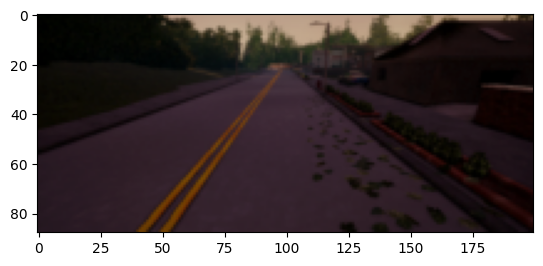

In [27]:
max_idx = 5 
for idx, (org_img, img, speed, command, target) in enumerate(val_dataset): 
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    plt.imshow(org_img)    
    img = img.to(device).unsqueeze(0)
    speed = speed.to(device).unsqueeze(0)
    command = command.to(device).unsqueeze(0)
    target = target.to(device).unsqueeze(0)   
    with torch.no_grad():
        out = model(img, speed, command)   
    print(f"{idx} Target | Prediction") 
    print(f"{target} | {out}")
    steer_loss = loss_fn(out[:, 0], target[:, 0])
    acc_loss = loss_fn(out[:, 1:], target[:, 1:])   
    print(f"steer_loss: {steer_loss}") 
    print(f"accel_loss: {acc_loss}")
    if idx == max_idx: 
        break  

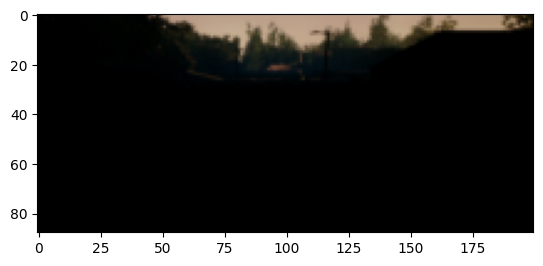

In [12]:
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
plt.imshow(org_img)


In [13]:
# model = Network(cfg)
# model = model.to(device)

In [14]:
img = img.to(device).unsqueeze(0)
print(f"img shape: {img.shape}")
speed = speed.to(device).unsqueeze(0)
command = command.to(device).unsqueeze(0)
target = target.to(device).unsqueeze(0)


img shape: torch.Size([1, 3, 88, 200])


In [16]:
model.eval()
model.to(device)
with torch.no_grad():
    out = model(img, speed, command)

In [17]:
out.shape

torch.Size([1, 3])

In [18]:
print(out)

tensor([[0.0292, 0.3400, 0.5255]])


In [19]:
print(target)

tensor([[0.1998, 1.0000, 0.0000]])


In [20]:
loss_fn = torch.nn.MSELoss()

In [21]:
steer_loss = loss_fn(out[:, 0], target[:, 0])
print(steer_loss)

tensor(0.0291)


In [22]:
acc_loss = loss_fn(out[:, 1:], target[:, 1:])
print(acc_loss)

tensor(0.3559)


In [35]:
"""
c = 0 
print("speed <> brake")
for org_img, img, speed, command, target in train_dataset: 
    if target[2] != 0.0: 
        c += 1  
        # print(f"{speed.item()} <> {target[2]}")

print(f"number of non zero brake values: {c}")""" 

speed <> brake
number of non zero brake values: 116101


657600

In [37]:
"""c = 0 
for org_img, img, speed, command, target in train_dataset: 
    if speed < 0.0: 
        c += 1  
        # print(f"{speed.item()} <> {target[2]}")

print(f"number of negative speed values: {c}")""" 

number of negative speed values: 76336
